In [1]:
# python libraries
import os
import sys
import dataclasses
from datetime import datetime
from pathlib import Path
from operator import methodcaller
from collections import OrderedDict
from dataclasses import dataclass
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Mapping,
    Callable
)
from enum import Enum
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# numpy
import numpy as np

# torch
import torch
import torchvision
from torch import nn
from torchvision import (
    transforms,
    datasets
    )
from torch.utils.data import DataLoader

try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

try:
    import torchinfo
except:
    print(f"[INFO] Installing the torchinfo")
    %pip install torchinfo
    import torchinfo

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper

In [2]:
## Connect Persistence memory
try :
    from google.colab import drive

    # Paths
    DRIVE_PATH = Path("/content/drive")
    MODEL_SAVE_PATH = Path("/content/drive/Othercomputers/My PC/drive/models")

    # mount drive
    drive.mount(str(DRIVE_PATH))
except:
    MODEL_SAVE_PATH = Path(os.getcwd())/"models"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Network in Network

In [4]:
@dataclass(eq=False)
class NiN(helper.Classifier):
    lr:int = 0.01
    num_classes:int = 10

    def __post_init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.nin_block(96,kernel=11,stride=4,padding=0),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(256,kernel=5,stride=1,padding=2),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(384,kernel=3,stride=1,padding=1),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Dropout(0.5),
            self.nin_block(self.num_classes,kernel=3,stride=1,padding=1),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )


    @staticmethod
    def nin_block(out_channels,kernel,stride,padding):
        return nn.Sequential(
            nn.LazyConv2d(out_channels,kernel_size=kernel,stride=stride,padding=padding),nn.ReLU(),
            # this two layer will do job of FC , this will  increase the non linearity.
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU(),
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU()          
        )
    @staticmethod
    def init_nin(module):
        if isinstance(module,(nn.Linear,nn.Conv2d)):
            nn.init.kaiming_normal_(module.weight)

In [5]:
NiN().layer_summary((1,1,224,224))

Sequential      output shape :(1, 96, 54, 54)
MaxPool2d       output shape :(1, 96, 26, 26)
Sequential      output shape :(1, 256, 26, 26)
MaxPool2d       output shape :(1, 256, 12, 12)
Sequential      output shape :(1, 384, 12, 12)
MaxPool2d       output shape :(1, 384, 5, 5)
Dropout         output shape :(1, 384, 5, 5)
Sequential      output shape :(1, 10, 5, 5)
AdaptiveAvgPool2d output shape :(1, 10, 1, 1)
Flatten         output shape :(1, 10)


c:\Users\Lenovo\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
torchinfo.summary(NiN(),input_size=(1,224,224)  ,  col_width=14,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)

Layer (type (var_name))                  Kernel Shape   Output Shape   Param #        Mult-Adds
NiN (NiN)                                --             [10, 1]        --             --
├─Sequential (net)                       --             [10, 1]        --             --
│    └─Sequential (0)                    --             [96, 54, 54]   --             --
│    │    └─Conv2d (0)                   [11, 11]       [96, 54, 54]   11,712         60,715,008
│    │    └─ReLU (1)                     --             [96, 54, 54]   --             --
│    │    └─Conv2d (2)                   [1, 1]         [96, 54, 54]   9,312          48,273,408
│    │    └─ReLU (3)                     --             [96, 54, 54]   --             --
│    │    └─Conv2d (4)                   [1, 1]         [96, 54, 54]   9,312          48,273,408
│    │    └─ReLU (5)                     --             [96, 54, 54]   --             --
│    └─MaxPool2d (1)                     3              [96, 26, 26]   --      

The total parameter size is reduce compare to pervious architecture like AlexNet ,VGG , since they had the FC layer 

# Training

In [7]:
model = NiN(lr=0.01)
data = helper.FashionMNIST(batch_size=128,resize=(224,224))
model.apply_init([(next(iter(data.train_dataloader())))[0]],model.init_nin)
trainer =helper.Trainer(max_epochs=10,model_save_path=MODEL_SAVE_PATH)

Training the model in cpu


Training the model in cuda


  0%|          | 0/10 [00:00<?, ?it/s]

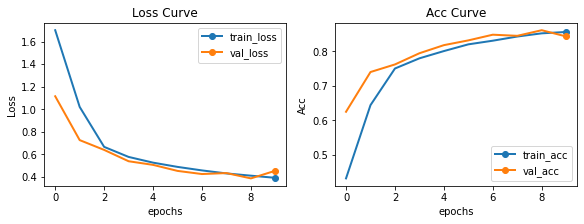

[Info] Saving the model at /content/drive/Othercomputers/My PC/drive/models/2023-02-04/NiN-12:16:43.pth


In [8]:
trainer.fit(model,data)

# Visual some output

In [11]:
# load the trained model
nin_model  = NiN()
nin_model.load_state_dict(torch.load(str(MODEL_SAVE_PATH/"2023-02-04/NiN-12 16 43.pth"),
map_location=device))

<All keys matched successfully>

In [12]:
for k,v in nin_model.named_parameters():
    print(k,tuple(v.shape))

net.0.0.weight (96, 1, 11, 11)
net.0.0.bias (96,)
net.0.2.weight (96, 96, 1, 1)
net.0.2.bias (96,)
net.0.4.weight (96, 96, 1, 1)
net.0.4.bias (96,)
net.2.0.weight (256, 96, 5, 5)
net.2.0.bias (256,)
net.2.2.weight (256, 256, 1, 1)
net.2.2.bias (256,)
net.2.4.weight (256, 256, 1, 1)
net.2.4.bias (256,)
net.4.0.weight (384, 256, 3, 3)
net.4.0.bias (384,)
net.4.2.weight (384, 384, 1, 1)
net.4.2.bias (384,)
net.4.4.weight (384, 384, 1, 1)
net.4.4.bias (384,)
net.7.0.weight (10, 384, 3, 3)
net.7.0.bias (10,)
net.7.2.weight (10, 10, 1, 1)
net.7.2.bias (10,)
net.7.4.weight (10, 10, 1, 1)
net.7.4.bias (10,)


In [13]:
X,y  = next(iter(data.train_dataloader()))
X.shape,y.shape

(torch.Size([128, 1, 224, 224]), torch.Size([128]))

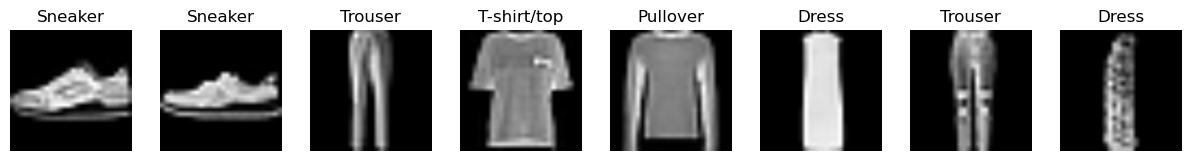

In [14]:
data.visualize(next(iter(data.train_dataloader())))

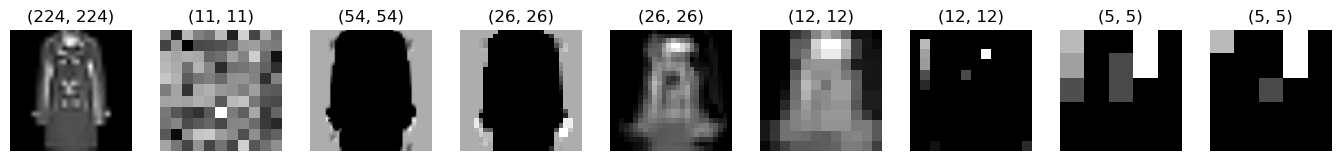

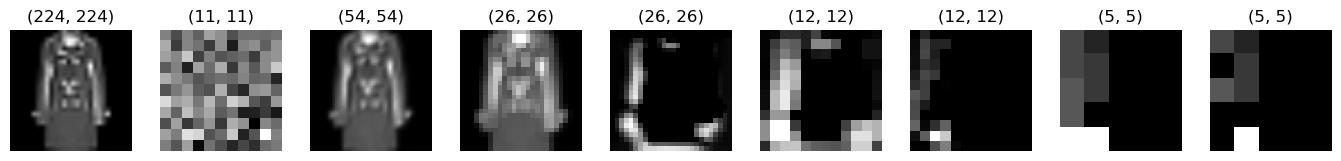

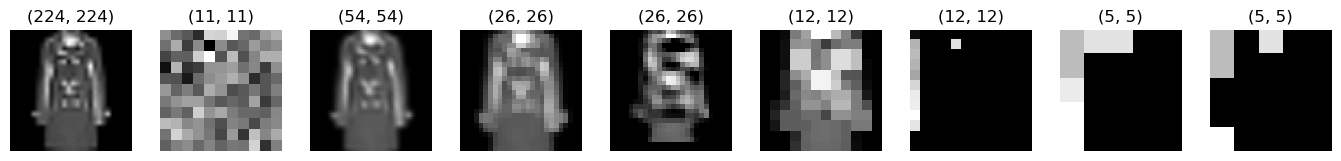

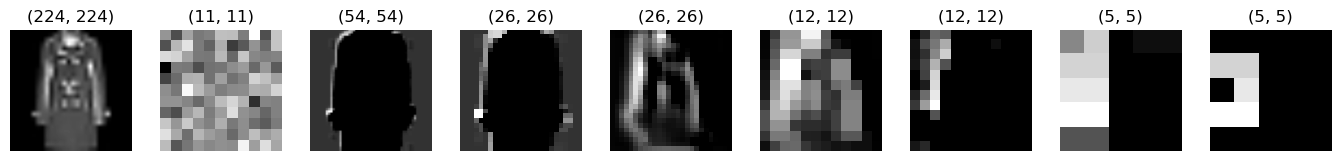

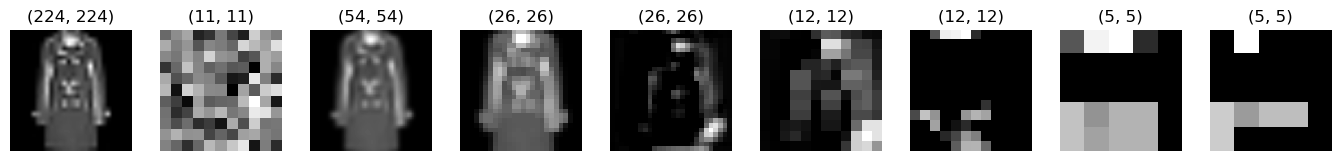

In [16]:
helper.visual_block(X[0],nin_model,1,8,0,trainer)

# Some Experiment

## Changing the number of 1x1 conv in each nin block.
1. Increase from two to three.
2. Decrease from two to one.

In [8]:
@dataclass(eq=False)
class NiNWithOne(helper.Classifier):
    """
    Output channel number is taken from the sequence [A133572 Row sums of triangle A133571]
    1, 4, 6, 16, 24, 64, 96, 256, 384, 1024......
    refer : https://oeis.org/A133572
    """
    lr:int = 0.01
    num_classes:int = 10
    

    def __post_init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.nin_block(96,11,4,0),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(256,kernel=5,stride=1,padding=2),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(384,3,1,2),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Dropout(0.5),
            self.nin_block(self.num_classes,kernel=3,stride=1,padding=1),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )

    @staticmethod
    def nin_block(out_channels,kernel,stride,padding):
        return nn.Sequential(
            nn.LazyConv2d(out_channels,kernel_size=kernel,stride=stride,padding=padding),nn.ReLU(),
            # modified to have one 1x1 conv
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU()
        )

    @staticmethod
    def init_nin(module):
        if isinstance(module,(nn.Linear,nn.Conv2d)):
            nn.init.kaiming_normal_(module.weight)

In [9]:
NiNWithOne().layer_summary((1,1,224,224))

Sequential      output shape :(1, 96, 54, 54)
MaxPool2d       output shape :(1, 96, 26, 26)
Sequential      output shape :(1, 256, 26, 26)
MaxPool2d       output shape :(1, 256, 12, 12)
Sequential      output shape :(1, 384, 14, 14)
MaxPool2d       output shape :(1, 384, 6, 6)
Dropout         output shape :(1, 384, 6, 6)
Sequential      output shape :(1, 10, 6, 6)
AdaptiveAvgPool2d output shape :(1, 10, 1, 1)
Flatten         output shape :(1, 10)


In [10]:
torchinfo.summary(NiNWithOne(),input_size=(1,224,224)  ,  col_width=14,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)

Layer (type (var_name))                  Kernel Shape   Output Shape   Param #        Mult-Adds
NiNWithOne (NiNWithOne)                  --             [10, 1]        --             --
├─Sequential (net)                       --             [10, 1]        --             --
│    └─Sequential (0)                    --             [96, 54, 54]   --             --
│    │    └─Conv2d (0)                   [11, 11]       [96, 54, 54]   11,712         60,715,008
│    │    └─ReLU (1)                     --             [96, 54, 54]   --             --
│    │    └─Conv2d (2)                   [1, 1]         [96, 54, 54]   9,312          48,273,408
│    │    └─ReLU (3)                     --             [96, 54, 54]   --             --
│    └─MaxPool2d (1)                     3              [96, 26, 26]   --             --
│    └─Sequential (2)                    --             [256, 26, 26]  --             --
│    │    └─Conv2d (0)                   [5, 5]         [256, 26, 26]  614,656        4

## Transferring the learned weight for nin_model to nin_with_one

In [17]:
nin_with_one =  NiNWithOne()

c:\Users\Lenovo\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [20]:
for k,v in nin_with_one.named_parameters():
    print(k,v)

net.0.0.weight <UninitializedParameter>
net.0.0.bias <UninitializedParameter>
net.0.2.weight <UninitializedParameter>
net.0.2.bias <UninitializedParameter>
net.2.0.weight <UninitializedParameter>
net.2.0.bias <UninitializedParameter>
net.2.2.weight <UninitializedParameter>
net.2.2.bias <UninitializedParameter>
net.4.0.weight <UninitializedParameter>
net.4.0.bias <UninitializedParameter>
net.4.2.weight <UninitializedParameter>
net.4.2.bias <UninitializedParameter>
net.7.0.weight <UninitializedParameter>
net.7.0.bias <UninitializedParameter>
net.7.2.weight <UninitializedParameter>
net.7.2.bias <UninitializedParameter>


In [25]:
nin_with_one.apply_init([next(iter(data.train_dataloader()))[0]],nin_with_one.init_nin)

In [31]:
for k,v in nin_with_one.named_parameters():
    print(k,v.shape,torch.mean(v).item())

net.0.0.weight torch.Size([96, 1, 11, 11]) 0.0007471214048564434
net.0.0.bias torch.Size([96]) 0.001544881146401167
net.0.2.weight torch.Size([96, 96, 1, 1]) 0.0017147852340713143
net.0.2.bias torch.Size([96]) -0.005607240367680788
net.2.0.weight torch.Size([256, 96, 5, 5]) 5.292867626849329e-06
net.2.0.bias torch.Size([256]) -0.0007017883472144604
net.2.2.weight torch.Size([256, 256, 1, 1]) 0.00015884012100286782
net.2.2.bias torch.Size([256]) 0.0016850304091349244
net.4.0.weight torch.Size([384, 256, 3, 3]) 2.6725530915427953e-05
net.4.0.bias torch.Size([384]) 0.00010854180436581373
net.4.2.weight torch.Size([384, 384, 1, 1]) 4.628216993296519e-05
net.4.2.bias torch.Size([384]) 0.0009158540633507073
net.7.0.weight torch.Size([10, 384, 3, 3]) -1.3041813872405328e-05
net.7.0.bias torch.Size([10]) -0.000655248761177063
net.7.2.weight torch.Size([10, 10, 1, 1]) 0.016010986641049385
net.7.2.bias torch.Size([10]) 0.005873654969036579


In [33]:
for k,v in nin_model.named_parameters():
    print(k,v.shape,torch.mean(v).item())

net.0.0.weight torch.Size([96, 1, 11, 11]) 0.0037587641272693872
net.0.0.bias torch.Size([96]) 0.015867237001657486
net.0.2.weight torch.Size([96, 96, 1, 1]) 0.0026520767714828253
net.0.2.bias torch.Size([96]) -0.00018765653658192605
net.0.4.weight torch.Size([96, 96, 1, 1]) 0.0002983227022923529
net.0.4.bias torch.Size([96]) 0.008395412005484104
net.2.0.weight torch.Size([256, 96, 5, 5]) 4.5128883357392624e-05
net.2.0.bias torch.Size([256]) 0.00130382739007473
net.2.2.weight torch.Size([256, 256, 1, 1]) 0.0003626644902396947
net.2.2.bias torch.Size([256]) 0.004320668056607246
net.2.4.weight torch.Size([256, 256, 1, 1]) -0.0006316113867796957
net.2.4.bias torch.Size([256]) 0.0002043702406808734
net.4.0.weight torch.Size([384, 256, 3, 3]) -7.330872904276475e-05
net.4.0.bias torch.Size([384]) 0.0019519954221323133
net.4.2.weight torch.Size([384, 384, 1, 1]) -0.00015233020531013608
net.4.2.bias torch.Size([384]) 0.00045333290472626686
net.4.4.weight torch.Size([384, 384, 1, 1]) -0.0015371

In [40]:
nin_with_one_params_name_set = set(dict(nin_with_one.named_parameters()).keys())
nin_model_params_name_set = set(dict(nin_model.named_parameters()).keys())

In [43]:
print(nin_model_params_name_set,nin_with_one_params_name_set)

{'net.2.2.weight', 'net.4.0.weight', 'net.4.4.bias', 'net.0.0.bias', 'net.2.2.bias', 'net.2.4.bias', 'net.0.2.weight', 'net.4.2.bias', 'net.2.0.weight', 'net.0.4.weight', 'net.7.0.bias', 'net.7.4.weight', 'net.2.4.weight', 'net.7.0.weight', 'net.4.2.weight', 'net.4.4.weight', 'net.7.2.weight', 'net.7.2.bias', 'net.0.4.bias', 'net.0.2.bias', 'net.0.0.weight', 'net.4.0.bias', 'net.7.4.bias', 'net.2.0.bias'} {'net.2.2.weight', 'net.4.0.weight', 'net.2.0.weight', 'net.7.2.weight', 'net.7.2.bias', 'net.4.2.weight', 'net.0.0.bias', 'net.7.0.bias', 'net.0.2.bias', 'net.0.0.weight', 'net.4.0.bias', 'net.2.2.bias', 'net.0.2.weight', 'net.4.2.bias', 'net.2.0.bias', 'net.7.0.weight'}


In [45]:
nin_with_one_params_name_set.intersection(nin_model_params_name_set) ==  nin_with_one_params_name_set

True

In [49]:
to_remove = nin_model_params_name_set.difference(nin_with_one_params_name_set)
to_remove

{'net.0.4.bias',
 'net.0.4.weight',
 'net.2.4.bias',
 'net.2.4.weight',
 'net.4.4.bias',
 'net.4.4.weight',
 'net.7.4.bias',
 'net.7.4.weight'}

In [46]:
nin_model_trained_state = torch.load(str(MODEL_SAVE_PATH/"2023-02-04/NiN-12 16 43.pth"),
map_location=device)

In [50]:
nin_model_trained_state.keys()

odict_keys(['net.0.0.weight', 'net.0.0.bias', 'net.0.2.weight', 'net.0.2.bias', 'net.0.4.weight', 'net.0.4.bias', 'net.2.0.weight', 'net.2.0.bias', 'net.2.2.weight', 'net.2.2.bias', 'net.2.4.weight', 'net.2.4.bias', 'net.4.0.weight', 'net.4.0.bias', 'net.4.2.weight', 'net.4.2.bias', 'net.4.4.weight', 'net.4.4.bias', 'net.7.0.weight', 'net.7.0.bias', 'net.7.2.weight', 'net.7.2.bias', 'net.7.4.weight', 'net.7.4.bias'])

In [51]:
for k in to_remove:
    nin_model_trained_state.pop(k,None)

In [53]:
nin_model_trained_state.keys() == nin_with_one_params_name_set

True

In [54]:
nin_with_one.load_state_dict(nin_model_trained_state)

<All keys matched successfully>

In [55]:
for k,v in nin_with_one.named_parameters():
    print(k,torch.mean(v).item())

net.0.0.weight 0.0037587641272693872
net.0.0.bias 0.015867237001657486
net.0.2.weight 0.0026520767714828253
net.0.2.bias -0.00018765653658192605
net.2.0.weight 4.5128883357392624e-05
net.2.0.bias 0.00130382739007473
net.2.2.weight 0.0003626644902396947
net.2.2.bias 0.004320668056607246
net.4.0.weight -7.330872904276475e-05
net.4.0.bias 0.0019519954221323133
net.4.2.weight -0.00015233020531013608
net.4.2.bias 0.00045333290472626686
net.7.0.weight 0.0005188440554775298
net.7.0.bias 0.01394121628254652
net.7.2.weight 0.015937888994812965
net.7.2.bias -0.0007953137392178178


## Training the model

In [56]:
trainer = helper.Trainer(max_epochs=10,model_save_path=MODEL_SAVE_PATH)

Training the model in cpu


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

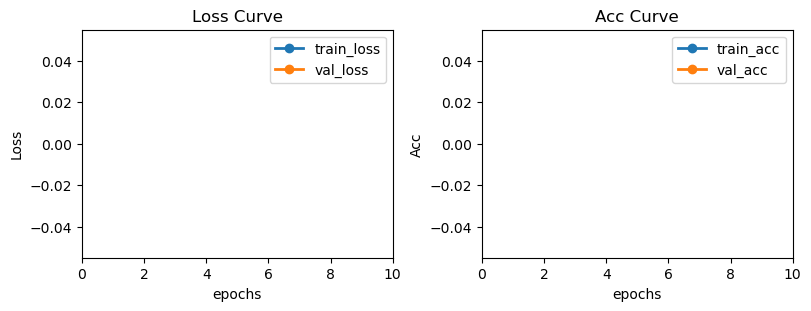

In [57]:
trainer.fit(nin_with_one,data)